# Trainig a simple graph



In these notes, I train a simple graph (Figure above) to give a desired value as output on node 1 fixing voltage on node 0, $V_0$ = 0V, and voltage at node 2, $V_2$ = 5V.
Sections:
- REPRODUCING RESULTS
- INTRODUCING NOISE
- COMPARISON BETWEEN DISCRETE AND CONTINUOUS RULE

In [7]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
sys.path.append('../../codes/')
import plotting_functions
import graphs
import training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


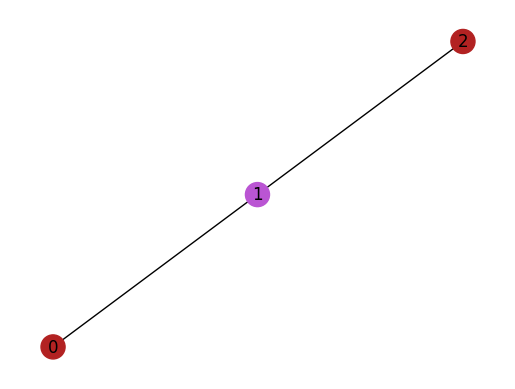

In [8]:
# Choose the graph: select desired parameters 
G = graphs.simple_graph(save_data=True)
fig, ax = plt.subplots()
plotting_functions.plot_graph(ax, fig, 'simple_graph')

# Don't change the graph G itself here below

## Reproducing results

I first reproduce the results to the ones in the paper of [Dillavou]. Here, they update the resistances on the network using an approximation to the coupled learning rule that stems from experimental limitations. In fact, they have discrete variable resistors so they fix the resistance update increment to $\delta R$.
To analyze, I plot the value of the voltage given as output by the network in the free state and compare it with the value of the voltage imposed in the constrained as well as with the desired voltage. 
I also show the behaviour of the resistances on the two edges, edge A connecting node 0-1 and egde B connecting node 1-2.

To check the status of the training, we show here the behaviour of the mean-squared error (MSE) as a function of training steps. It is defined as[]

$C = \frac{1}{2} \sum_{T} \left( V_{T}^{F} - V_{T} \right)$

General Parameters: 

iterations: 100, tollerance on potential difference= 1e-16 

Parameters Resistance Update: 

eta_r = 1, alpha_r = 5000.0, gamma_r = 5000.0, initial resistance=50 

Parameters Conductance Update: 

eta_c = 0.001, alpha_c = 0.0005, gamma_c = 0.5, initial conductances=0.02 



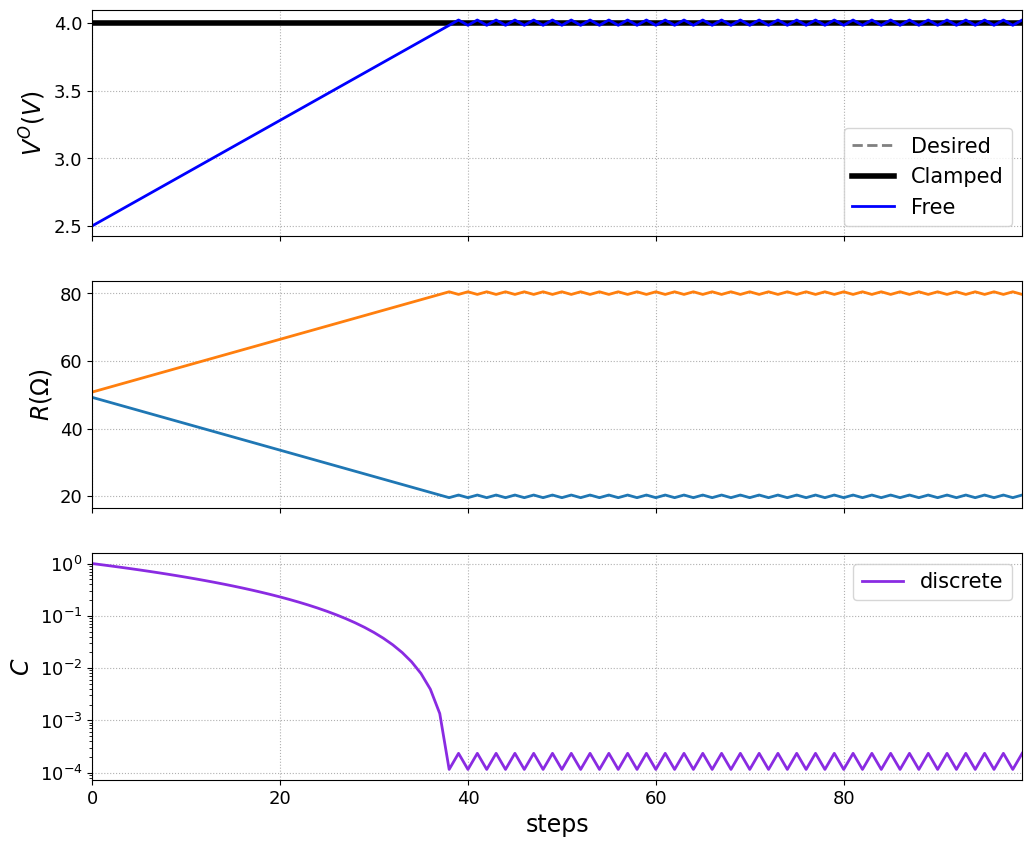

In [6]:
G_train = G.copy(as_view=False)
G_train = training.training_epoch(G_train, rule = 'discrete', update = 'resistances', mse=True, resistances_change=True, voltages_simple=True, show_parameters=True)
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'discrete',update = 'resistances')
plotting_functions.plot_resistances(ax[1], G_train, rule = 'discrete')
plotting_functions.plot_mse(ax[2], fig, rule = 'discrete', update = 'resistances', zoom_in=0)

Here I want to train the system to give 4V at node 1. The error gets significantly decreased, but the system gets stuck in a configuration where it can not decrease error further. This is due to the fact the the discrete increment of the resistances is too big compared to the difference between the free and clamped state.

Comparing with the results in the paper [FIG. 2 (b)], I see similar results. However, they also introduce noise here treated in the next section.

## Introducing noise

Experimentally, the noise would come from a wrong measurement of the potentials in free $\Delta V^{F}$ and clamped states $\Delta V^{C}$. This, in turn, affects the choise in the sign of the update when the magnitude of the error in the measurement is comparable with the magnitude of $\Delta V = \Delta V^{C} - \Delta V^{F}$.

Looking above, the network gets stuck in two configurations, from one it gets trained to another and vice-versa. I printed the number of steps and the difference in potential to understand for what value of $\Delta V$ this happens. I saw that happens when $\Delta V \sim 0.01$. In the paper, they found that this also corresponds to the experimental value when the noise is dominant. To simulate the noise, theupdating rule gets modified in such a way that a random variable is added to the difference in the potentials 
$ \Delta V^{C} - \Delta V^{F} + \sigma$
with $\sigma$ a random variable with uniform distribution of width 2*0.01 and ceneterd in zero. In this way, if the difference in potential is smaller than 0.01, than the $\sigma$ has 50% probability of changing its sign. Here below the results with noise.

General Parameters: 

iterations: 100, tollerance on potential difference= 1e-16 

Parameters Resistance Update: 

eta_r = 0.5, alpha_r = 5000.0, gamma_r = 10000.0, initial resistance=50 

Parameters Conductance Update: 

eta_c = 0.001, alpha_c = 0.0005, gamma_c = 0.5, initial conductances=0.02 



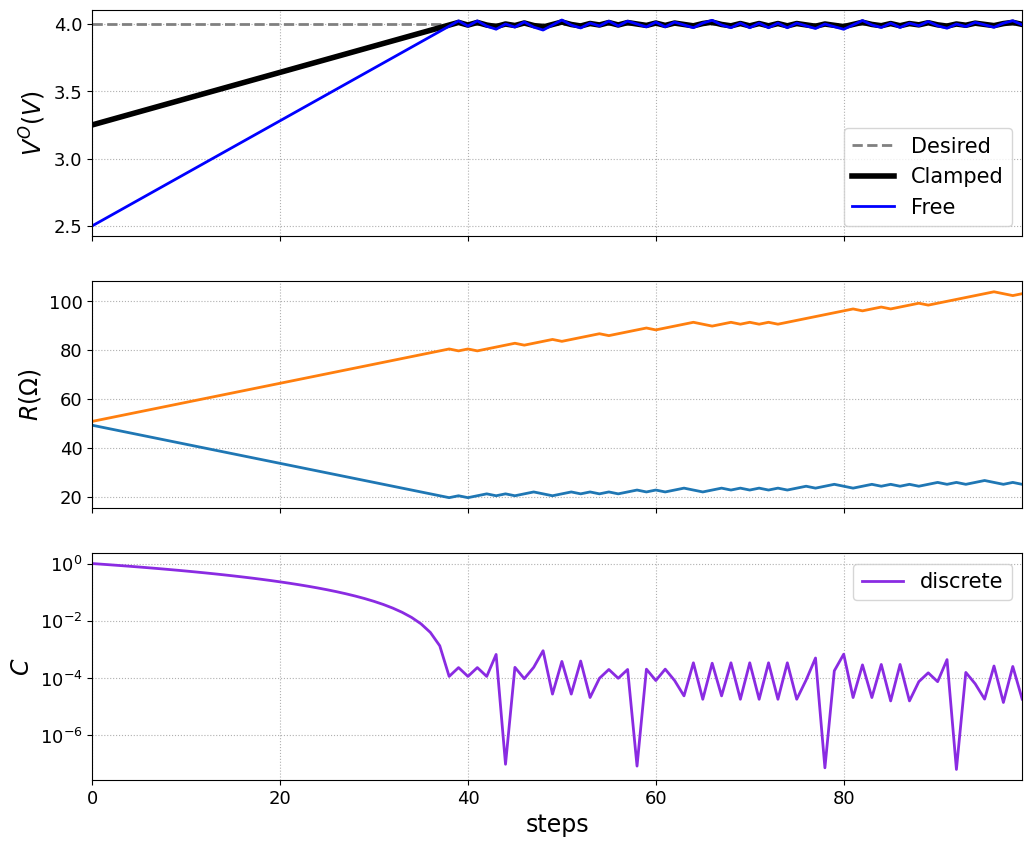

In [8]:
G_train = G.copy(as_view=False)
G_train = training.training_epoch(G_train, rule = 'discrete', update = 'resistances', mse=True, resistances_change=True, voltages_simple=True, show_parameters=True, noise=True)
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'discrete',update = 'resistances')
plotting_functions.plot_resistances(ax[1], G_train, rule = 'discrete')
plotting_functions.plot_mse(ax[2], fig, rule = 'discrete', update = 'resistances', zoom_in=0)

The advantage of adding noise it that it enables to get out of stck configurations and explore the solution space more. However, a part from some lucky events that significantly decrease the error (look at the C going to $10^{-6}$), the error in the generation of the desired output remain of the same order of magnitude in general.

## Comparison between continuous and discrete rules

We train the graph using two types of updating rules. The coninous rule from coupled learning and the discrete rule in [Dillavou] which is motivated by experimantal results. The implementation of the latter is done to be able to validate the simulation code.

The goal in this poject is to construct a physical system that is able to implement the countinuous rule. Therefore, here I will make a comparison between the experimental system available today (in the paper) and the one we would like to construct.

In [12]:
# Train the graph
G1 = G.copy(as_view=False)
G2 = G.copy(as_view=False)
G1 = training.training_epoch(G1, rule = 'discrete', update = 'resistances', mse=True, resistances_change=True, voltages_simple=True, noise=True)
G2 = training.training_epoch(G2, rule = 'continuous', update = 'resistances', mse=True, resistances_change=True, voltages_simple=True)

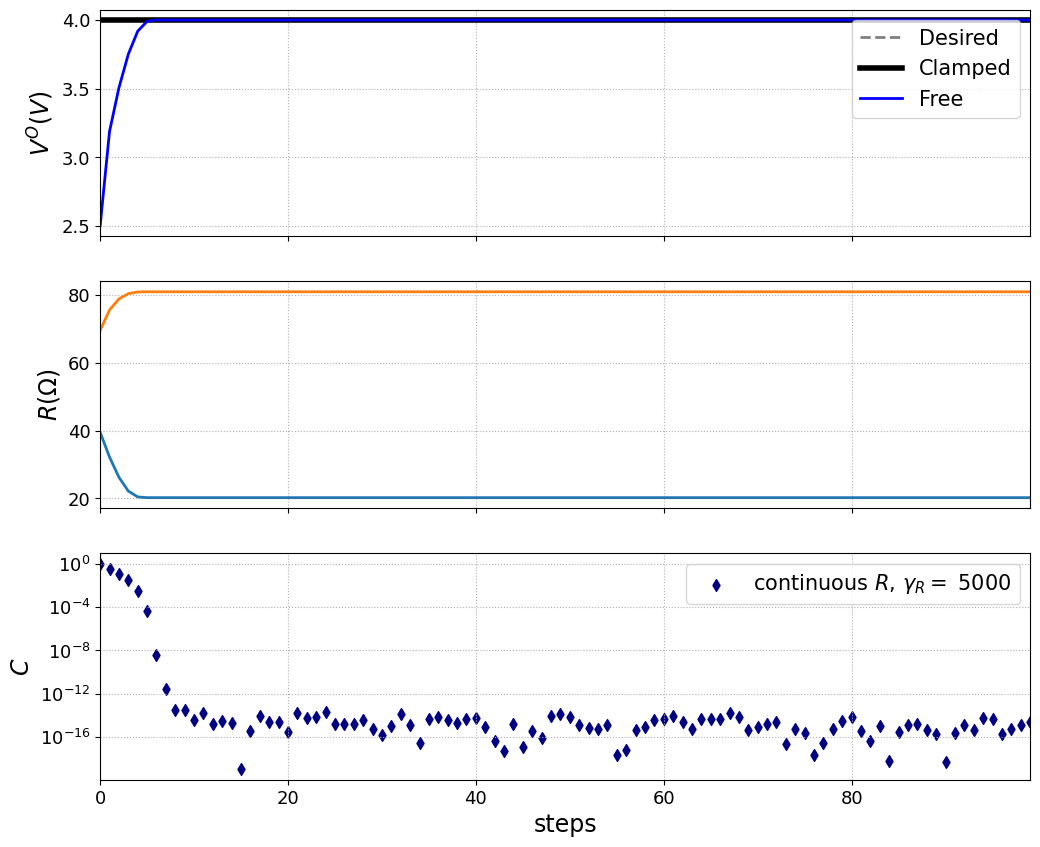

In [5]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'continuous', update = 'resistances')
plotting_functions.plot_resistances(ax[1], G2, rule = 'continuous')
plotting_functions.plot_mse(ax[2], fig, rule = 'continuous', update = 'resistances', zoom_in=0, scatter=True)

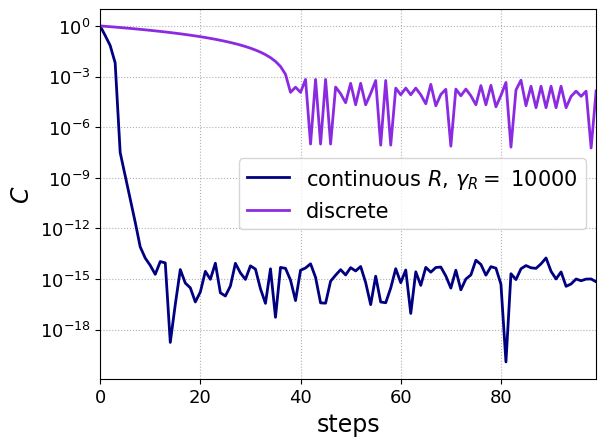

In [13]:
fig, ax = plt.subplots()
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update = 'resistances', zoom_in=0)
plotting_functions.plot_mse(ax, fig, rule = 'discrete', update = 'resistances', zoom_in=0)

In [82]:
print(G1.nodes[1]['voltage'])
print(G2.nodes[1]['voltage'])

4.029043626751918
3.999999990063065


## Updating conductances instead

Is updating resistance $R$ or conductance $g=1/R$ the same in the continuous version of the rule?

In [48]:
G3 = G.copy(as_view=False)
G4 = G.copy(as_view=False)
G3 = training.training_epoch(G3, rule = 'continuous', update = 'resistances', mse=True, 
                             resistances_change=True, voltages_simple=True, 
                             show_parameters=True)
G4 = training.training_epoch(G4, rule = 'continuous', update = 'conductances', mse=True, 
                             voltages_simple=True, conductances_change = True)

General Parameters: 

iterations: 20, tollerance on potential difference= 1e-16 

Parameters Resistance Update: 

eta_r = 0.5, alpha_r = 5000.0, gamma_r = 10000.0, initial resistance=50 

Parameters Conductance Update: 

eta_c = 0.5, alpha_c = 0.0005, gamma_c = 0.001, initial conductances=0.02 



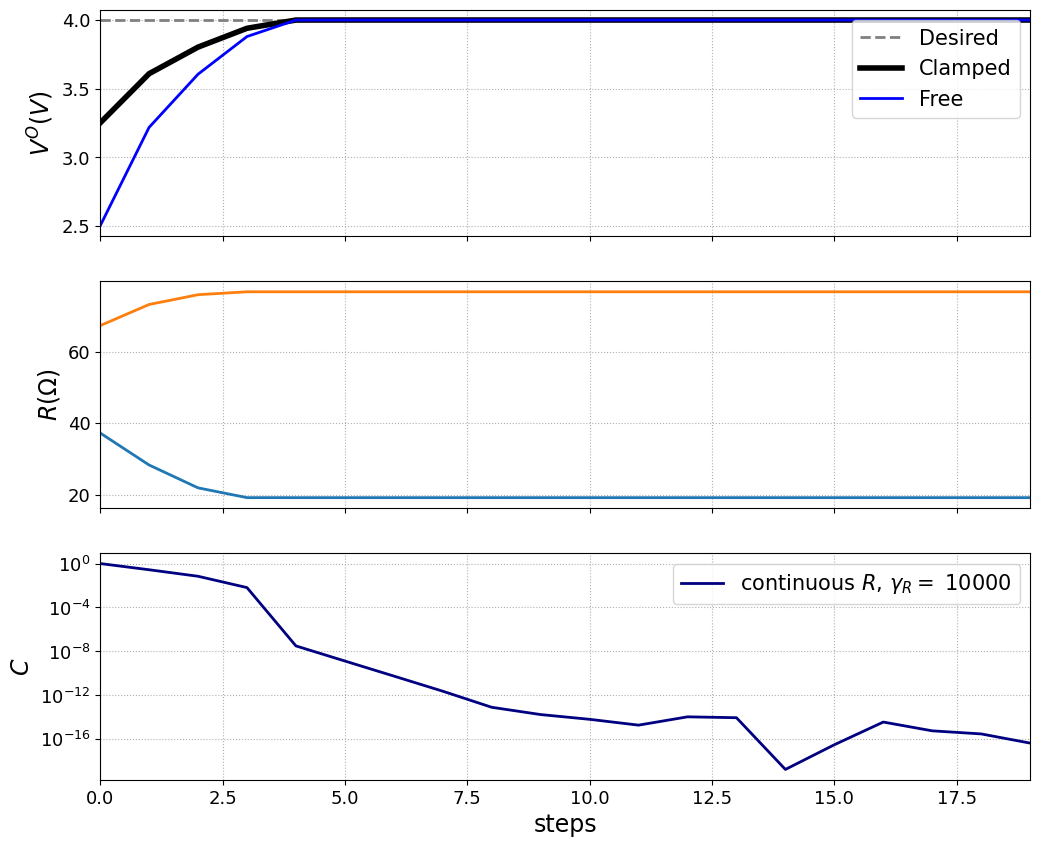

In [15]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'continuous', update = 'resistances')
plotting_functions.plot_resistances(ax[1], G3, rule = 'continuous')
plotting_functions.plot_mse(ax[2], fig, rule = 'continuous', update = 'resistances', zoom_in=0)

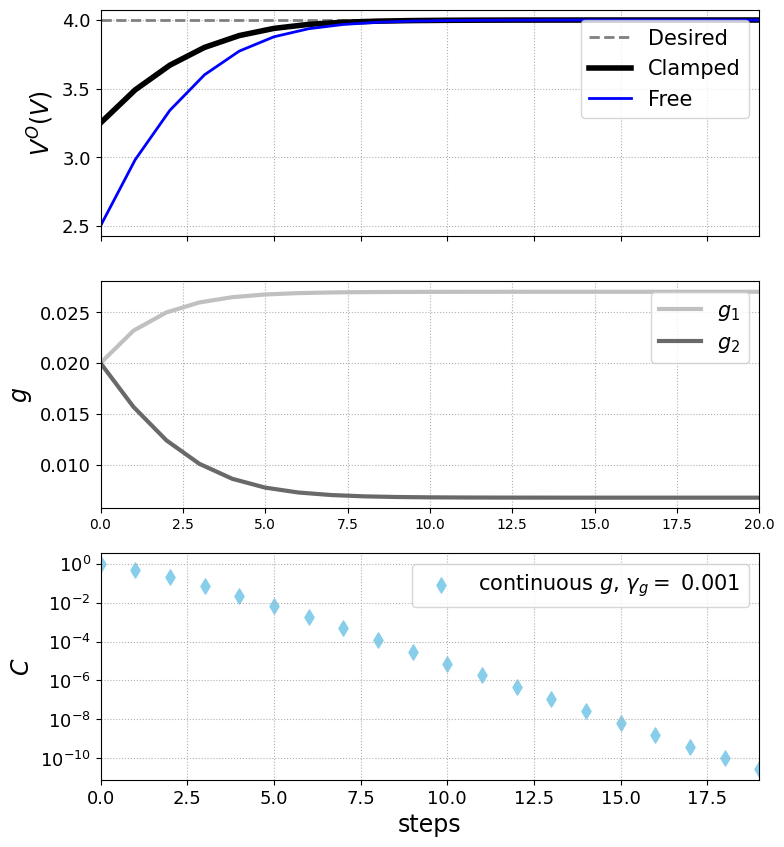

In [55]:
fig, ax = plt.subplots(3,1, figsize = (8.5,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'continuous', update = 'conductances')
plotting_functions.plot_conductaces(ax[1], G4)
plotting_functions.plot_mse(ax[2], fig, rule = 'continuous', update = 'conductances', 
                            zoom_in=0, scatter=True) 

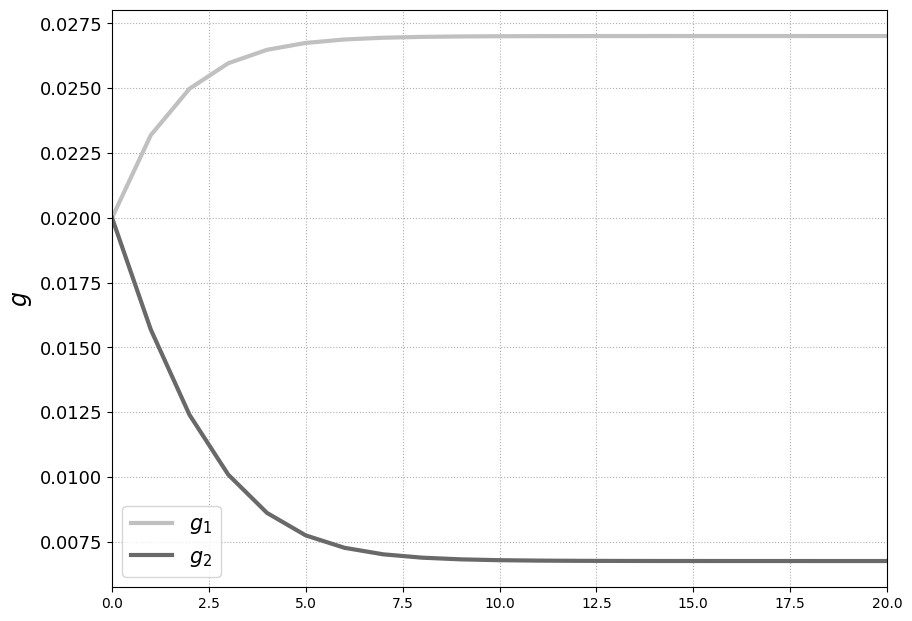

In [59]:
fig, ax = plt.subplots(figsize = (10,7.5))

plotting_functions.plot_conductaces(ax, G4)

In [17]:
G7 = G.copy(as_view=False)
G7 = training.training_epoch(G7, rule = 'discrete', update = 'conductances', mse=True, 
                             voltages_simple=True, conductances_change = True)

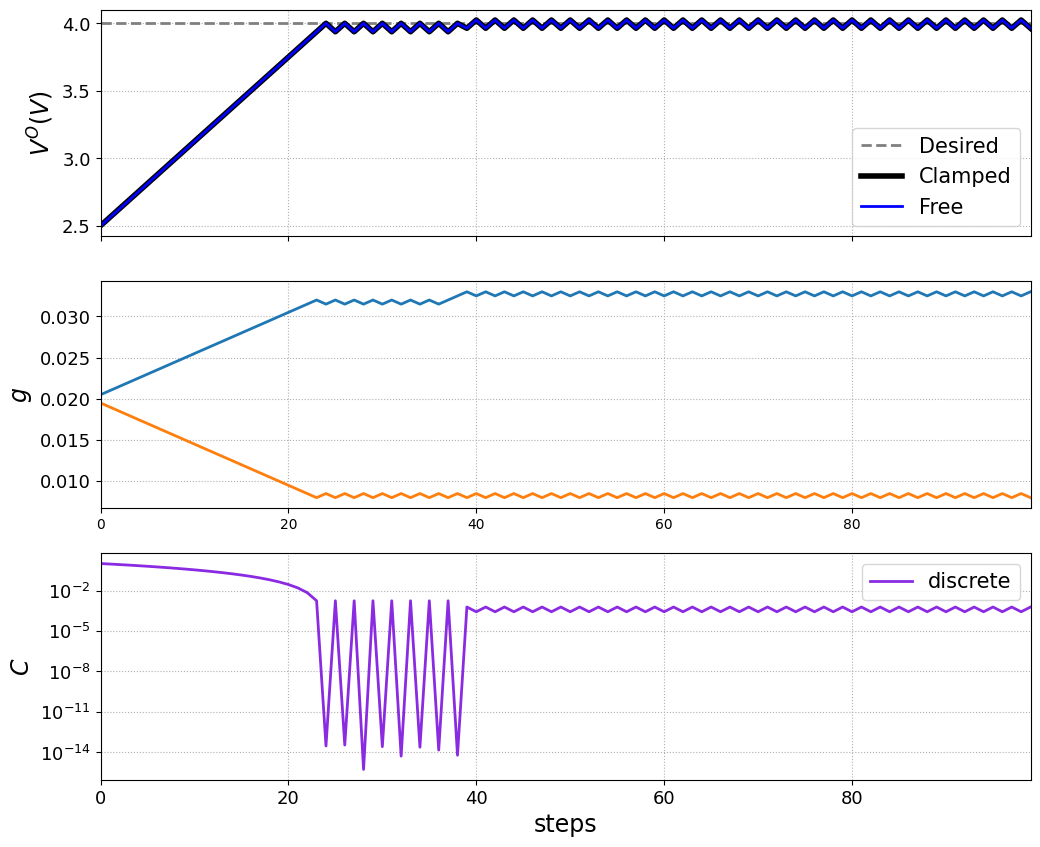

In [18]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'discrete', update = 'conductances')
plotting_functions.plot_conductaces(ax[1], G4)
plotting_functions.plot_mse(ax[2], fig, rule = 'discrete', update = 'conductances', 
                            zoom_in=0, scatter=True) 

In [19]:
G7 = G.copy(as_view=False)
G7 = training.training_epoch(G7, rule = 'discrete', update = 'conductances', mse=True, 
                             voltages_simple=True, conductances_change = True, noise=True)

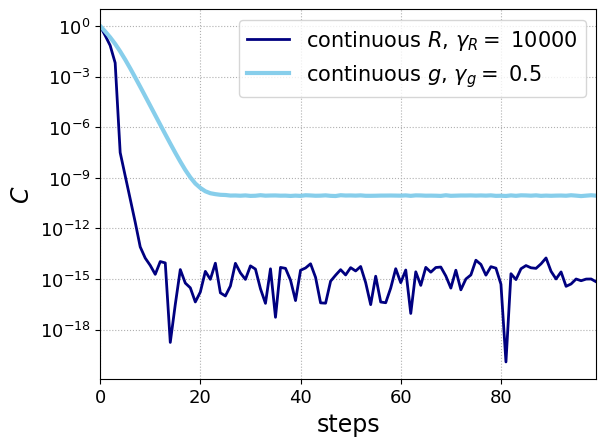

In [20]:
fig, ax = plt.subplots()
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update='resistances', zoom_in=0)
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update='conductances', zoom_in=0)

## Introducing a new updating rule

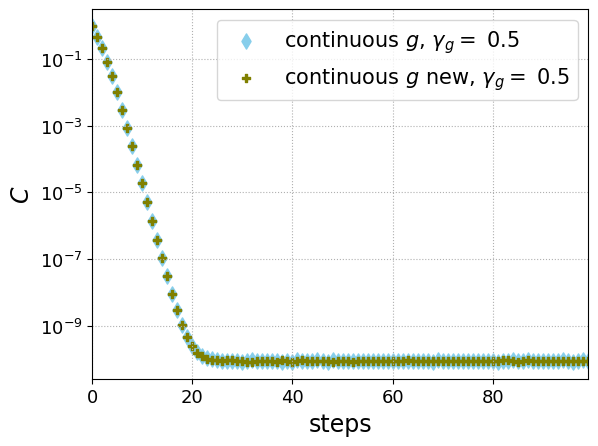

In [21]:
G5 = G.copy(as_view=False)
G6 = G.copy(as_view=False)
fig, ax = plt.subplots()
G5 = training.training_epoch(G5, rule = 'continuous', update = 'conductances', mse=True, 
                             voltages_simple=False, conductances_change = True)
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update='conductances', zoom_in=0,
                            scatter=True)
G6 = training.training_epoch(G6, rule = 'continuous', update = 'conductances', mse=True, 
                             voltages_simple=False, conductances_change = True, new_rule=True)
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update='conductances', zoom_in=0, 
                            new_rule=True, scatter=True)

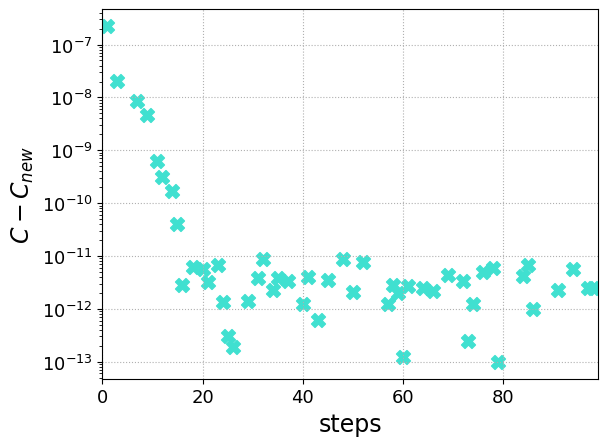

In [22]:
fig, ax = plt.subplots()
plotting_functions.difference_mse(ax)

## Introducing noise

Experimentally, the noise would come from a wrong measurement of the difference in potential in free $\Delta V^{F}$ and clamped states $\Delta V^{C}$. 

Looking above, the network gets stuck in two configurations, from one it gets trained to another and vice-versa. I printed the number of step and the difference in potential to understand for what value of $\Delta V = \Delta V^{C} - \Delta V^{F}$ this happens. I saw that happens for $\Delta V \sim 0.01$

In [6]:
# Train the graph

G1 = G.copy()
G2 = G.copy()

G1 = training.training_epoch(G1, rule = 'discrete', mse=True, update='resistances',
                             resistances_change=True, voltages_simple=True, noise=False)
G2 = training.training_epoch(G2, rule = 'continuous', mse=True, update='resistances',
                             resistances_change=True, voltages_simple=True, noise=False)


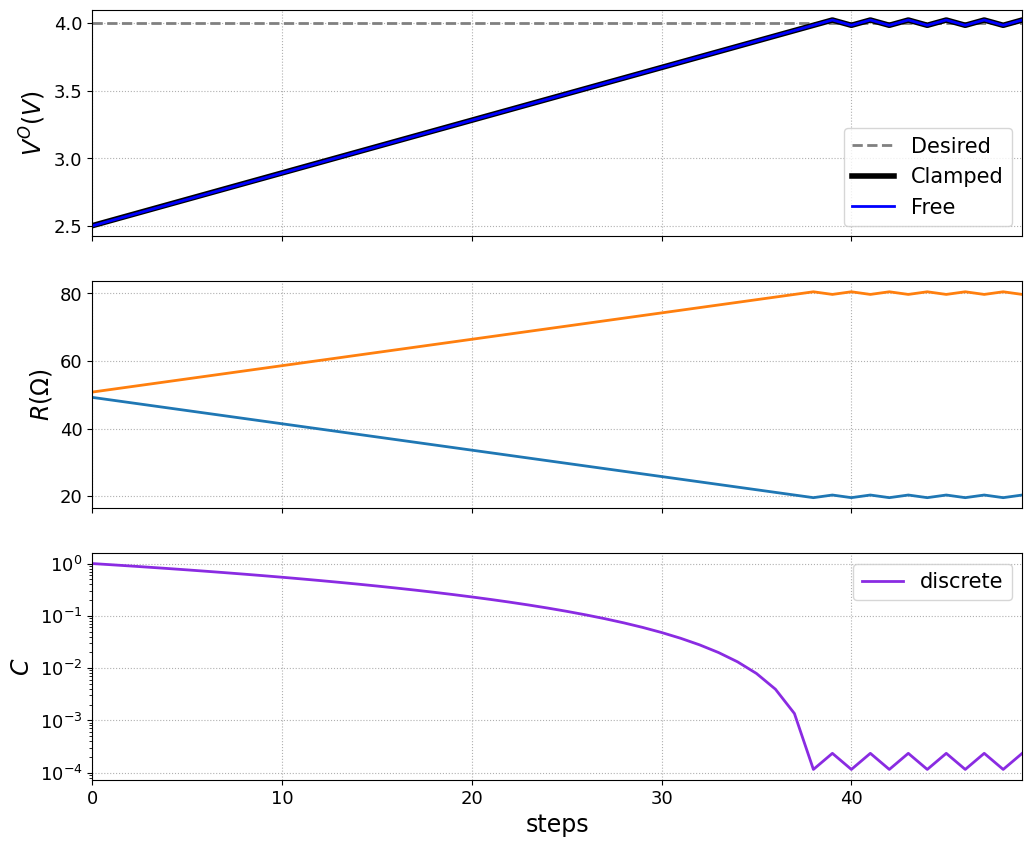

In [29]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'discrete', update='resistances')
plotting_functions.plot_resistances(ax[1], G1, rule = 'discrete')
plotting_functions.plot_mse(ax[2], fig, rule = 'discrete', update='resistances', zoom_in=0)

NameError: name 'G2' is not defined

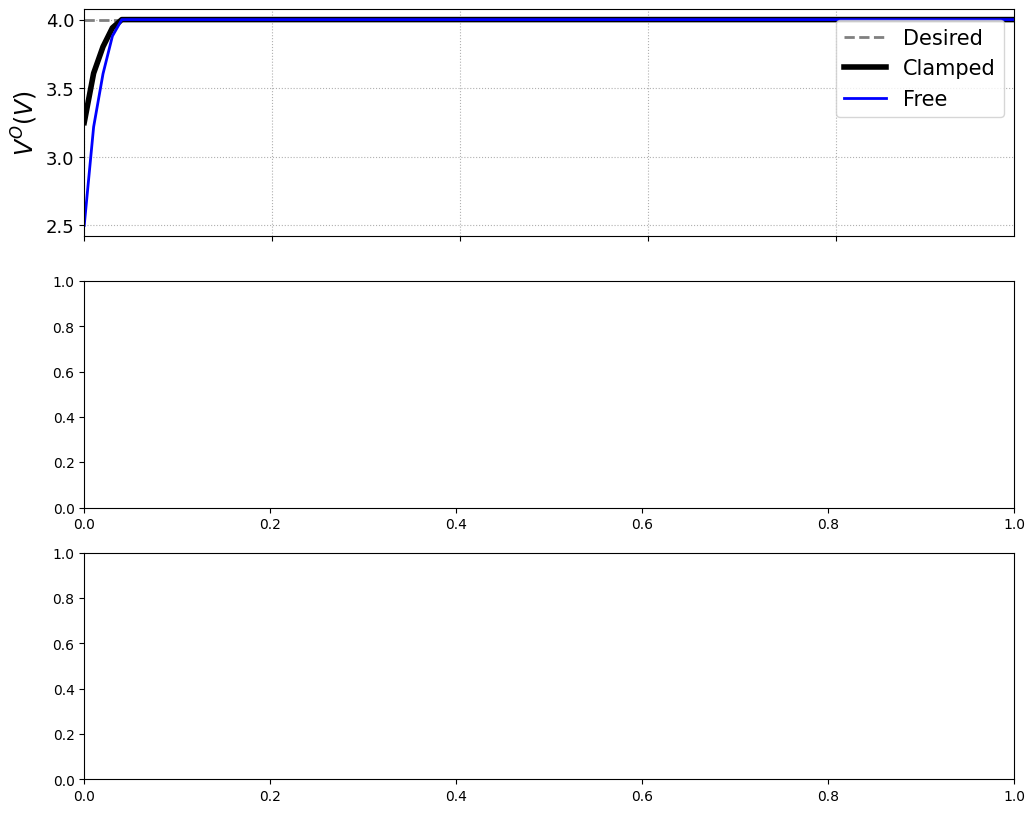

In [5]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'continuous', update='resistances')
plotting_functions.plot_resistances(ax[1], G2, rule = 'continuous')
plotting_functions.plot_mse(ax[2], fig, rule = 'continuous', update='resistances')

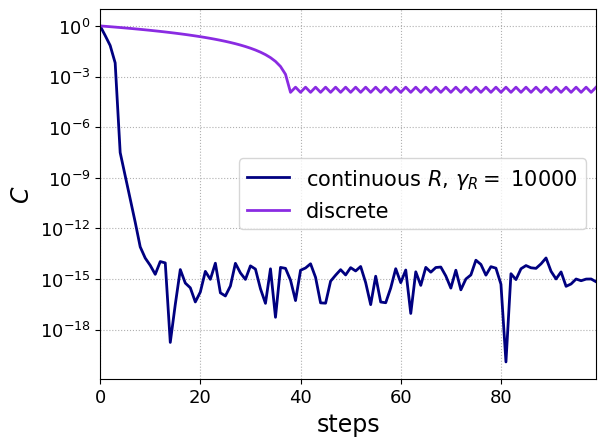

In [25]:
fig, ax = plt.subplots()
plotting_functions.plot_mse(ax, fig, rule = 'continuous', update='resistances', zoom_in=0)
plotting_functions.plot_mse(ax, fig, rule = 'discrete', update='resistances', zoom_in=0)

----------------------------------------------------

TypeError: simple_plot_voltages() missing 1 required positional argument: 'update'

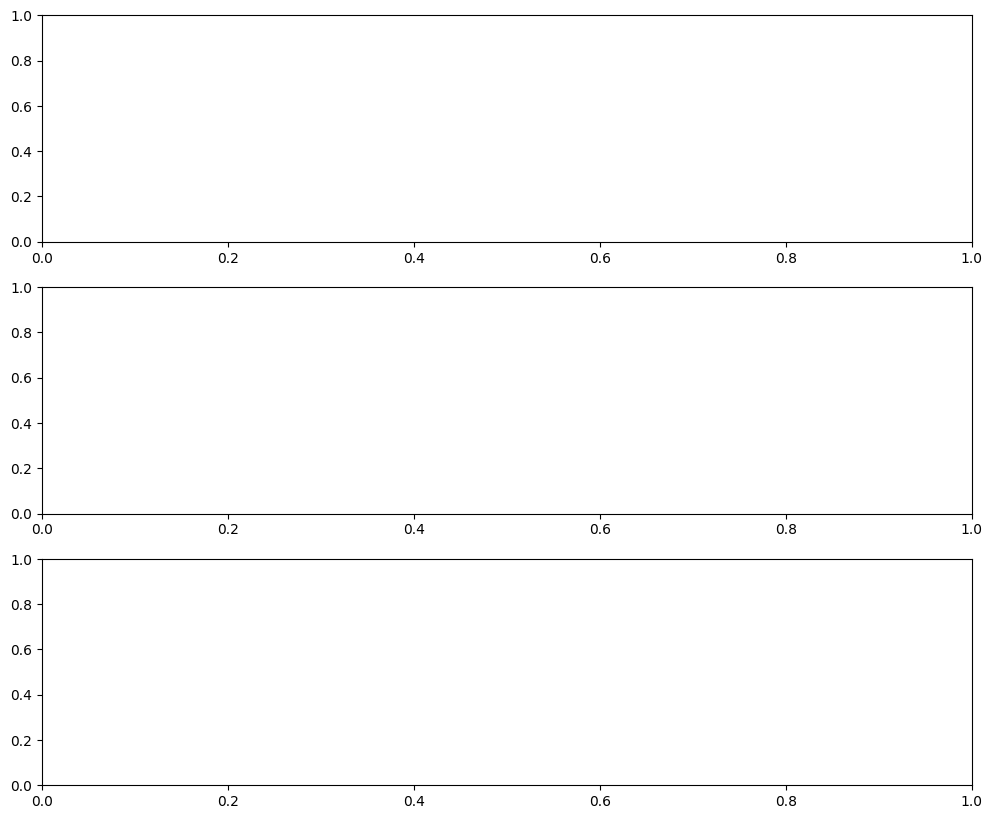

In [26]:
fig, ax = plt.subplots(3,1, figsize = (12,10))
plotting_functions.simple_plot_voltages(ax[0], rule = 'continuous')
plotting_functions.plot_resistances(ax[1], G2, rule = 'continuous')
plotting_functions.plot_mse(ax[2], fig, rule = 'continuous')

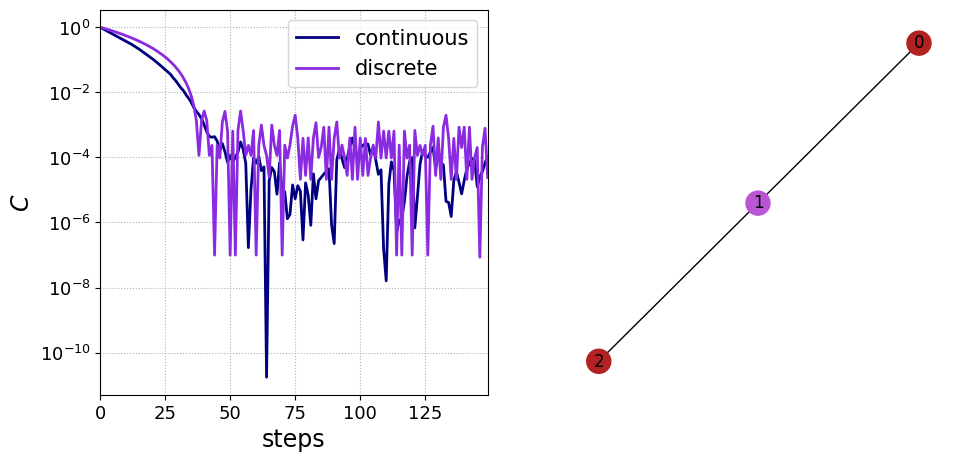

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (11,5))
plotting_functions.plot_graph(ax[1], fig, 'simple_graph')
plotting_functions.plot_mse(ax[0], fig, rule = 'continuous')
plotting_functions.plot_mse(ax[0], fig, rule = 'discrete')

TypeError: plot_resistances() missing 1 required positional argument: 'rule'

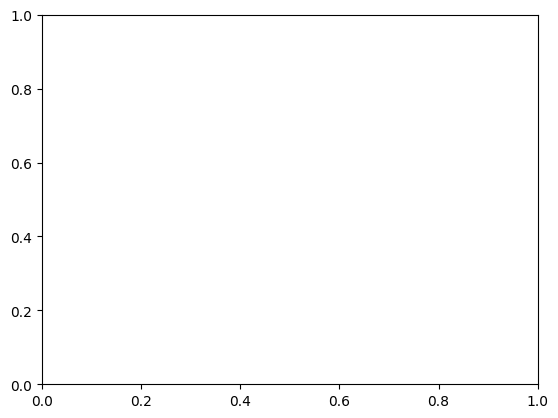

In [ ]:
fig, ax = plt.subplots()
plotting_functions.plot_resistances(ax, G1)

# for node in G1.nodes:
#     if G1.nodes[node]['type'] == 'target':
#         print(G1.nodes[node]['voltage'])